## Tempering from a normal distribution towards a shifted normal
This notebook implements the tempering towards another normal distribution

In [1]:
import numpy as np
import numexpr as ne
from numba import jit
from matplotlib import pyplot as plt
import sys
sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc/")
#sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc/smc_sampler_functions")

Specify dimension

In [5]:
dim = 10
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Defining the sampler parameters

In [6]:
N_particles = 2**10
T_time = 40
move_steps_hmc = 50
move_steps_rw_mala = 100
ESStarget = 0.9
M_num_repetions = 1
epsilon = 1.
epsilon_hmc = .1
verbose = False
targetmean = np.ones(dim)*1.
correlation = 0.99*np.ones((dim, dim))
np.fill_diagonal(correlation, 1)
#diag_variance = np.linspace(start=0.01, stop=100, num=dim)
diag_variance = np.linspace(start=0.1, stop=0.2, num=dim)
targetvariance = np.dot(np.diag(diag_variance**0.5), correlation).dot(np.diag(diag_variance**0.5))
#targetvariance = np.eye(dim)
targetvariance_inv = np.linalg.inv(targetvariance)
l_targetvariance_inv = np.linalg.cholesky(targetvariance_inv)
factor_variance = 10.
parameters = {'dim' : dim, 
              'N_particles' : N_particles, 
              'targetmean': targetmean, 
              'targetvariance':targetvariance,
              'targetvariance_inv':targetvariance_inv,
              'l_targetvariance_inv':l_targetvariance_inv,
              'df' : 5,
              'factor_variance': factor_variance
             }
from smc_sampler_functions.functions_smc_help import sequence_distributions
from smc_sampler_functions.proposal_kernels import proposalmala, proposalrw, proposalhmc, proposalhmc_parallel
from smc_sampler_functions.functions_smc_main import smc_sampler

maladict = {'proposalkernel_tune': proposalmala,
                      'proposalkernel_sample': proposalmala,
                      'proposalname' : 'MALA',
                      'target_probability' : 0.65,
                      'covariance_matrix' : np.eye(dim), 
                      'L_max' : 1,
                      'epsilon' : np.array([epsilon]),
                      'epsilon_max' : np.array([epsilon]),
                      'tune_kernel': 'fearnhead_taylor',
                      'sample_eps_L' : True,
                      'verbose' : verbose,
                      'move_steps': move_steps_rw_mala,
                      'T_time' : T_time,
                      'autotempering' : True,
                      'ESStarget': ESStarget,
                      'adaptive_covariance' : True,
                      'quantile_test': 0.1,
            'score_test': False
                      }

rwdict = {'proposalkernel_tune': proposalrw,
                      'proposalkernel_sample': proposalrw,
                      'proposalname' : 'RW',
                      'target_probability' : 0.3,
                      'covariance_matrix' : np.eye(dim), 
                      'L_max' : 1,
                      'epsilon' : np.array([epsilon]),
                      'epsilon_max' : np.array([epsilon]),
                      'tune_kernel': 'fearnhead_taylor',
                      'sample_eps_L' : True,
                      'verbose' : verbose,
                      'move_steps': move_steps_rw_mala,
                      'T_time' : T_time,
                      'autotempering' : True,
                      'ESStarget': ESStarget,
                      'adaptive_covariance' : True,
                      'quantile_test': 0.1,
          'score_test': False
                      }

hmcdict_ft_adaptive = {'proposalkernel_tune': proposalhmc,
                      'proposalkernel_sample': proposalhmc_parallel,
                      'proposalname' : 'HMC_L_random_ft_adaptive',
                      'target_probability' : 0.9,
                      'covariance_matrix' : np.eye(dim), 
                      'L_max' : 50,
                      'epsilon' : np.array([epsilon_hmc]),
                      'epsilon_max' : np.array([epsilon_hmc]),
                      'accept_reject' : True,
                      'tune_kernel': 'fearnhead_taylor',
                      'sample_eps_L' : True,
                      'parallelize' : False,
                      'verbose' : verbose,
                      'move_steps': move_steps_hmc, 
                      'mean_L' : False,
                      'T_time' : T_time,
                      'autotempering' : True,
                      'ESStarget': ESStarget,
                      'adaptive_covariance' : True,
                      'quantile_test': 0.1,
                       'score_test': False
                      }

hmcdict_ours_adaptive = {'proposalkernel_tune': proposalhmc,
                      'proposalkernel_sample': proposalhmc_parallel,
                      'proposalname' : 'HMC_L_random_ours_adaptive',
                      'target_probability' : 0.9,
                      'covariance_matrix' : np.eye(dim), 
                      'L_max' : 50,
                      'epsilon' : np.array([epsilon_hmc]),
                      'epsilon_max' : np.array([epsilon_hmc]),
                      'accept_reject' : True,
                      'tune_kernel': 'ours_simple',
                      'sample_eps_L' : True,
                      'parallelize' : False,
                      'verbose' : verbose,
                      'move_steps': move_steps_hmc, 
                      'mean_L' : False,
                      'T_time' : T_time,
                      'autotempering' : True,
                      'ESStarget': ESStarget,
                      'adaptive_covariance' : True,
                      'quantile_test': 0.1, 
                      'score_test': False
                      }


from smc_sampler_functions.functions_smc_main import repeat_sampling
from smc_sampler_functions.target_distributions import priorlogdens, priorgradlogdens, priorsampler
from smc_sampler_functions.target_distributions import targetlogdens_normal, targetgradlogdens_normal
from smc_sampler_functions.target_distributions import targetlogdens_normal_mix, targetgradlogdens_normal_mix
from smc_sampler_functions.target_distributions import targetlogdens_student, targetgradlogdens_student


priordistribution = {'logdensity' : priorlogdens, 'gradlogdensity' : priorgradlogdens, 'priorsampler': priorsampler}
targetdistribution = {'logdensity' : targetlogdens_normal, 'gradlogdensity' : targetgradlogdens_normal, 'target_name': 'normal'}
#targetdistribution = {'logdensity' : targetlogdens_normal_mix, 'gradlogdensity' : targetgradlogdens_normal_mix, 'target_name': 'normal_mix'}
#targetdistribution = {'logdensity' : targetlogdens_student, 'gradlogdensity' : targetgradlogdens_student, 'target_name': 'student'}
#samplers_list_dict = [maladict, hmcdict, rwdict]
samplers_list_dict = [hmcdict_ft_adaptive, hmcdict_ours_adaptive, maladict, rwdict]#, hmcdict_ours_adaptive]


temperedist = sequence_distributions(parameters, priordistribution, targetdistribution)
res_repeated_sampling, res_first_iteration = repeat_sampling(samplers_list_dict, temperedist,  parameters, M_num_repetions=M_num_repetions, save_res=False, save_name = '')
if False: 
    res_repeated_sampling, res_first_iteration1 = repeat_sampling(samplers_list_dict, temperedist,  parameters, M_num_repetions=M_num_repetions, save_res=False, save_name = '')
    parameters['quantile_test'] = 0.9
    res_repeated_sampling, res_first_iteration2 = repeat_sampling(samplers_list_dict, temperedist,  parameters, M_num_repetions=M_num_repetions, save_res=False, save_name = '')
    parameters['quantile_test'] = 0.5
    res_repeated_sampling, res_first_iteration3 = repeat_sampling(samplers_list_dict, temperedist,  parameters, M_num_repetions=M_num_repetions, save_res=False, save_name = '')




repetition 0 of 1
Now runing smc sampler with HMC_L_random_ft_adaptive kernel
Sampler ended at time 1230 after 18.810970068 seconds 

Now runing smc sampler with HMC_L_random_ours_adaptive kernel
Sampler ended at time 637 after 21.3772439957 seconds 

Now runing smc sampler with MALA kernel
Sampler ended at time 3392 after 35.9667510986 seconds 

Now runing smc sampler with RW kernel
Sampler ended at time 4326 after 31.5359418392 seconds 



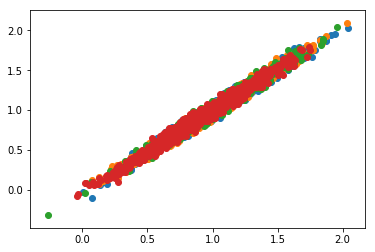

In [11]:
plt.scatter(x=res_first_iteration[0]['particles_resampled'][:,0], y=res_first_iteration[0]['particles_resampled'][:,1]); 
plt.scatter(x=res_first_iteration[1]['particles_resampled'][:,0], y=res_first_iteration[1]['particles_resampled'][:,1]); 
plt.scatter(x=res_first_iteration[2]['particles_resampled'][:,0], y=res_first_iteration[2]['particles_resampled'][:,1]);
plt.scatter(x=res_first_iteration[3]['particles_resampled'][:,0], y=res_first_iteration[3]['particles_resampled'][:,1]);

plt.show()

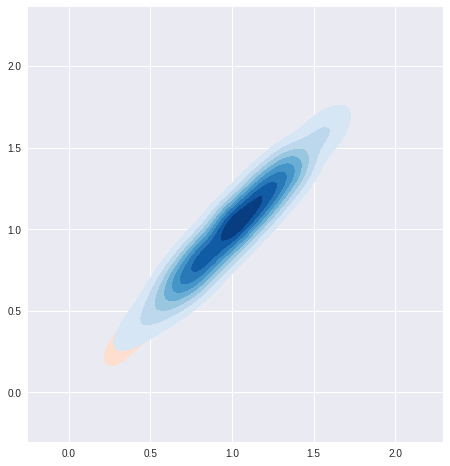

In [29]:
import seaborn as sns
#sns.jointplot(res_first_iteration[3]['particles_resampled'][:,0], res_first_iteration[3]['particles_resampled'][:,1], kind='kde'); plt.show()
#sns.jointplot(res_first_iteration[1]['particles_resampled'][:,0], res_first_iteration[1]['particles_resampled'][:,1], kind='kde'); plt.show()
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(res_first_iteration[3]['particles_resampled'][:,0], res_first_iteration[3]['particles_resampled'][:,1], 
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(res_first_iteration[1]['particles_resampled'][:,0], res_first_iteration[1]['particles_resampled'][:,1], 
                 cmap="Blues", shade=True, shade_lowest=False)
plt.show()

In [38]:
res_first_iteration[0]['particles_resampled'].var(axis=0)

array([ 0.10510933,  0.1254772 ,  0.14173545,  0.17694499,  0.19932004])

\begin{tabular}{lrrrr}
\hline
                            &   log MSE mean &   log MSE var &   log MSE Z &   mean runtime sec \\
\hline
 HMC\_L\_random\_ft\_adaptive   &          -8.84 &         -9.64 &       -6.60 &               3.51 \\
 HMC\_L\_random\_ours\_adaptive &          -8.57 &         -9.72 &       -7.10 &               4.57 \\
 MALA                       &          -8.40 &         -9.44 &       -7.50 &               2.51 \\
 RW                         &          -8.79 &         -9.80 &       -7.12 &               5.25 \\
\hline
\end{tabular}


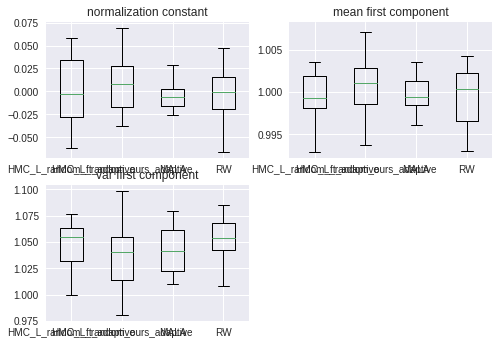

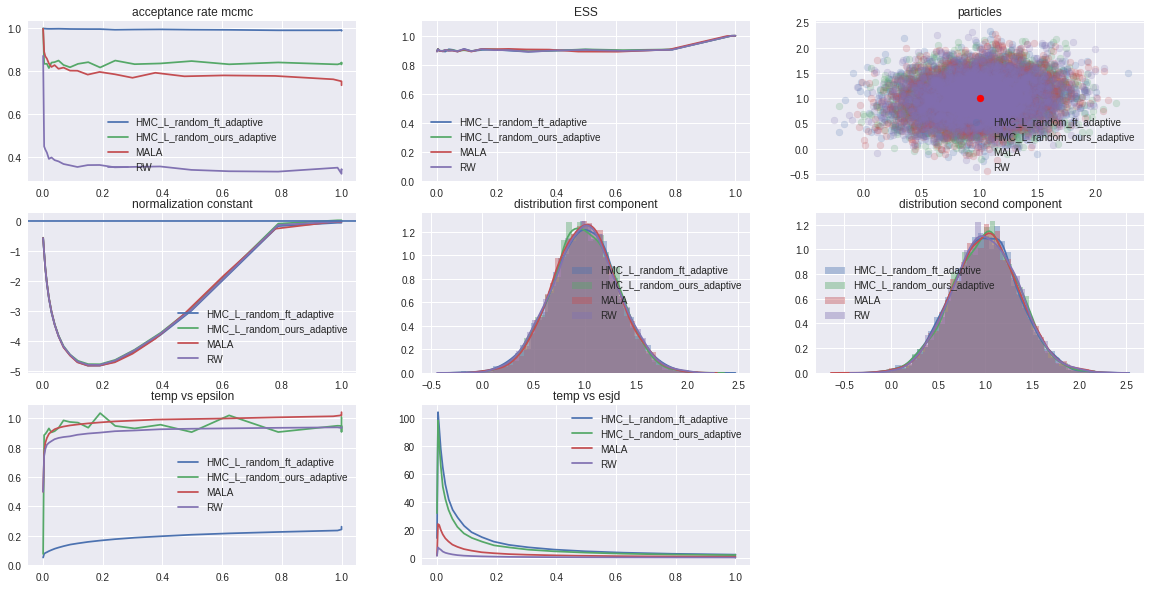

In [39]:
from smc_sampler_functions.functions_smc_plotting import plot_repeated_simulations, plot_results_single_simulation
plot_repeated_simulations(res_repeated_sampling)
plot_results_single_simulation(res_first_iteration)


In [7]:
from smc_sampler_functions import standard_mh_sampler
parameters_mh = {'dim' : dim, 
              'N_particles' : 1, 
              'factor_variance': factor_variance,
              'T_time' : 10
             }
import copy
maladict_mh = copy.copy(maladict)
maladict_mh['epsilon'] = np.array([.05])
maladict_mh['covariance_matrix'] = np.eye(dim)#targetvariance#
hmcdict_mh =  copy.copy(hmcdict_ft_adaptive)
hmcdict_mh['L_steps'] = 50
res_dict = standard_mh_sampler.parallel_mh_sampler(temperedist, proposalkerneldict=hmcdict_mh, parameters=parameters_mh)

Now runing mh sampler with HMC_L_random_ft_adaptive kernel
Sampler ended at time 10 after 19.746981144 seconds 



In [8]:
20*1000/

333

In [89]:
print res_dict['acceptance_rate']
res_dict['particles'][:,:,1000:].mean(axis=2).mean(axis=0)#-res_repeated_sampling['mean_array'][2,0,:]

0.03284


array([ 1.00924068,  0.99572456,  0.98097766,  0.99434854,  0.98026796])

def acf(x, length=20):
    res_list = []
    for k in range(1,length):
        res = np.corrcoef(x['particles'][0,0,1000:-k], x['particles'][0,0,1000+k:])[1,0]
        if res<0:
            break
        res_list.append(res)
    return np.array(res_list)
corrs = acf(res_dict)
print 1000/(1+2*corrs.sum())

In [12]:
from scipy.stats import multivariate_normal
N_samples = 10**6
samples = np.random.multivariate_normal(mean=targetmean, cov=targetvariance, size=N_samples)
logweight_proposal = multivariate_normal.logpdf(samples, mean=targetmean, cov=targetvariance)
logweight_target = temperedist.logdensity(samples, temperature=1.)

samples.shape

diff = logweight_target - logweight_proposal
a_max = (diff).max()
logweights = diff - a_max - np.log(np.exp(diff-a_max).sum())
print (((np.exp(logweights)).sum()**2/(np.exp(logweights)**2).sum()))/N_samples
print np.log(np.exp(diff).mean()), sum(res_first_iteration[0]['Z_list'])

1.0
0.0 -0.0105689721917


In [6]:
print (res_first_iteration[0]['particles_resampled']<0).mean()
print (res_first_iteration[1]['particles_resampled']<0).mean()
print (res_first_iteration[2]['particles_resampled']<0).mean()
#np.unique(res_first_iteration[1]['temp_list']).shape
#np.unique(res_first_iteration[2]['temp_list']).shape
factor_iterations = res_repeated_sampling['L_mean'].mean(axis=1)*res_repeated_sampling['temp_steps'].mean(axis=1)
print factor_iterations
print res_repeated_sampling['names_samplers']
print np.log((((res_repeated_sampling['particles_array']>0).mean(axis=0).mean(axis=0)-0.5)**2).mean(axis=1)*factor_iterations)
#print factor_iterations


0.4890625
0.5083984375
0.498046875
[ 421.13371094  457.97519531  115.5         404.1       ]
['HMC_L_random_ft_adaptive', 'HMC_L_random_ours_adaptive', 'MALA', 'RW']
[-3.50480108 -3.85184684 -5.88144677 -3.72874213]


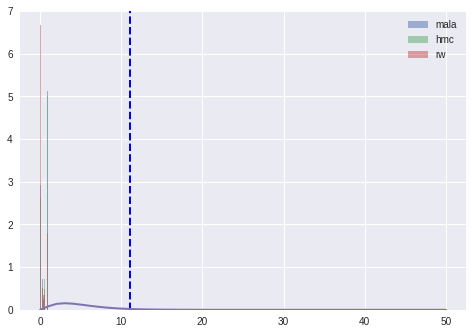

moves per temperature step
['HMC_L_random_ft_adaptive', 'HMC_L_random_ours_adaptive', 'MALA', 'RW']
[0.4878048780487805, 0.47619047619047616, 0.17094017094017094, 0.047961630695443645]


In [7]:
from scipy.stats import chi2
from matplotlib import pyplot as plt
plt.hist([res["test_statistic"] for res in res_first_iteration[0]['test_dict_list']], label="mala", alpha=0.5, density=True)
plt.hist([res["test_statistic"] for res in res_first_iteration[1]['test_dict_list']], label="hmc", alpha=0.5, density=True)
plt.hist([res["test_statistic"] for res in res_first_iteration[2]['test_dict_list']], label="rw", alpha=0.5, density=True)
plt.axvline(chi2.ppf(0.95, dim), color='b', linestyle='dashed', linewidth=2)
x = np.linspace(0,50) 
h = plt.plot(x, chi2.pdf(x, dim), lw=2)
#plt.xscale('log')
plt.legend()
plt.show()
print('moves per temperature step')
print(res_repeated_sampling['names_samplers'])
print([np.unique(res['temp_list']).shape[0]/(len(res["test_dict_list"])*1.) for res in res_first_iteration])

In [8]:
res_mh1 = np.array([np.array([res["test_statistic"], res['temp']]) for res in res_first_iteration1[2]['test_dict_list']])
res_mh2 = np.array([np.array([res["test_statistic"], res['temp']]) for res in res_first_iteration2[2]['test_dict_list']])
res_mh3 = np.array([np.array([res["test_statistic"], res['temp']]) for res in res_first_iteration3[2]['test_dict_list']])
plt.scatter(x=res_mh1[:,1], y=res_mh1[:,0])
plt.show()
unique1, counts1 = np.unique(res_mh1[:,1], return_counts=True)
unique2, counts2 = np.unique(res_mh2[:,1], return_counts=True)
unique3, counts3 = np.unique(res_mh3[:,1], return_counts=True)
#print unique, counts
plt.plot(unique1, counts1, label='0.95')
plt.plot(unique2, counts2, label='0.9')
plt.plot(unique3, counts3, label='0.5'); plt.legend()
plt.show()

NameError: name 'res_first_iteration1' is not defined